### External Libraries and Configuration

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
#import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample


from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.style as style

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
og_data = "C:\\Study\\Stevens\\CS 513\\Final Project\\github\\CS513-Project\\data\\original_data.csv"
major_data = "C:\\Study\\Stevens\\CS 513\\Final Project\\github\\CS513-Project\\data\\Majors_goruped_proper.xlsx"
score_data = "C:\\Study\\Stevens\\CS 513\\Final Project\\github\\CS513-Project\\data\\score.csv"
world_rank_data = "C:\\Study\\TP\\2023 QS World University Rankings.csv"

# Data Preprocessing

In [3]:
def fix_misaligned_rows(raw_data):
    """
    <Add description>
    """
    for i in raw_data[ (raw_data.journalPubs.notnull()) & (raw_data.journalPubs.str.startswith("http"))].index:
        vals = raw_data.iloc[i,9:18]
        keys = vals.keys()
        vals = vals[1:]
        raw_data.loc[i, keys[:-1]] = vals.values
        raw_data.loc[i, "confPubs"] = 0
    return raw_data


def remove_all_null(raw_data):
    """
    <Add description>
    """
    raw_data = raw_data.dropna( axis=0, thresh=15)
    # to refresh index after every removed rows | needed for "cgpa" conversion
    raw_data.reset_index(inplace=True,drop=True)
    return raw_data


def extract_intake(raw_data):
    """
    <Add description>
    """
    raw_data["intake"] = raw_data["termAndYear"].str.split(expand=True)[0]
    return raw_data


def extract_year(raw_data):
    """
    <Add description>
    """
    raw_data["year"] = raw_data["termAndYear"].str.split(expand=True)[2]
    raw_data['year'] = pd.to_numeric(raw_data['year'], errors='coerce')
    # Lambda function to take values less than 23, say x, casting it to 2000+x
    cast_year = lambda x: x if x>22 else 2000+x
    raw_data["year"] = raw_data["year"].apply(cast_year)
    # Lambda function to remove years out of range (1990, 2022)
    remove_out_of_range = lambda x: x if x>1990 and x<=2022 else np.NaN
    raw_data["year"] = raw_data["year"].apply(remove_out_of_range)
    return raw_data

def process_program(raw_data):
    """
    <Add description>
    """
    # Lambda function to replace all only PhD with NaN, and others with MS
    remove_only_phd = lambda x: np.NaN if x=="PhD" else "MS"
    raw_data["program"] = raw_data["program"].apply(remove_only_phd)
    return raw_data

def process_confPubs(raw_data):
    """
    <Add description>
    """
    raw_data["confPubs"] = raw_data["confPubs"].fillna(0)
    raw_data['confPubs'] = raw_data['confPubs'].astype('int')
    return raw_data


def process_toeflScore(raw_data):
    """
    <Add description>
    """
    raw_data.toeflScore[raw_data['toeflScore'] > 120] = raw_data.toeflScore.mean()
    raw_data['toeflScore'].fillna(int(raw_data['toeflScore'].mean()), inplace=True)
    return raw_data


def process_gre(raw_data):
    """
    <Add description>
    """
    raw_data.greV = raw_data.greV.astype(float)
    raw_data.greQ = raw_data.greQ.astype(float)
    raw_data['greV'].values[raw_data['greV'].values > 800] = np.nan
    raw_data['greQ'].values[raw_data['greQ'].values > 800] = np.nan
    raw_data['greQ'].values[raw_data['greQ'].values < 130] = np.nan
    raw_data['greV'].values[raw_data['greV'].values < 130] = np.nan
    raw_data['greV'].values[(raw_data['greV'].values > 170) & (raw_data['greV'].values < 200)] = np.nan
    raw_data['greQ'].values[(raw_data['greQ'].values > 170) & (raw_data['greQ'].values < 200)] = np.nan

    def convert_gre(df, col):
        score_df = pd.read_csv(score_data)
        df[col] = df[col].apply(lambda x: 10 * round(float(x)/10) if  (not np.isnan(x) and (x > 170)) else x)
        if col == "greV":
          replace_dict = dict(zip(score_df.old, score_df.newV))
        if col == "greQ":
          replace_dict = dict(zip(score_df.old, score_df.newQ))
        df_new = df.replace({col:replace_dict})
        return df_new

    raw_data = convert_gre(raw_data, "greV")
    raw_data = convert_gre(raw_data, "greQ")
    raw_data.greV.fillna(round(raw_data.greV.mean()), inplace=True)
    raw_data.greQ.fillna(round(raw_data.greQ.mean()), inplace=True)

    raw_data['greA'].values[raw_data['greA'].values > 6] = np.nan
    raw_data.greA = raw_data.greA.fillna(raw_data['greA'].mode()[0])
    return raw_data


def process_major(raw_data):
    """
    <Add description>
    """
    majors_df = pd.read_excel(major_data)
    v = [majors_df[x].tolist() for x in majors_df.columns.values]
    c = majors_df.columns.values
    dict_major = {}
    for k,val in zip(c,v):
        for i in val:
            if pd.isna(i):
                continue
            dict_major[i] = k

    raw_data = raw_data.replace({"major":dict_major})

    dept_maj_dict = {'0': 'Computer Science',
    'Manufacturing Engineering': 'Materials Science & Manufacturing',
    'Chemical Engg.': 'Chemical',
    'Computer Engg': 'Computer Science Engineering',
    'Computer Engineering': 'Computer Science Engineering',
    'Compter Science & Engineering': 'Computer Science Engineering',
    'ECE': 'Electronics Engineering',
    'Mechanical': 'Mechanical Engineering',
    'Mechanical Engineering': 'Mechanical Engineering',
    'Computer Science and Egnieering': 'Computer Science Engineering',
    'Computer Science & Engineering': 'Computer Science Engineering',
    'Biomedical Engg.': 'Biotechnology & Computational Biology',
    'MBA': 'Business Administration & Management',
    'Electrical Engineering': 'Electronics Engineering',
    'Eller college of management': 'Business Administration & Management',
    'Biotechnology': 'Biotechnology & Computational Biology',
    'electronics': 'Electronics Engineering',
    'Electrical & Electronics': 'Electronics Engineering',
    'CHBE': 'Chemical',
    'computer science and engineering': 'Computer Science Engineering'}

    raw_data['major'] = raw_data.apply(
      lambda row: dept_maj_dict[row["department"]] if pd.isna(row['major']) else row["major"],
      axis=1)
    return raw_data


def process_internExp(raw_data):
    """
    <Add description>
    """
    raw_data["internExp"] = raw_data["internExp"].fillna(0)
    return raw_data


def process_journalPubs(raw_data):
    """
    <Add description>
    """ 
    raw_data['journalPubs']=raw_data['journalPubs'].fillna(0)
    raw_data['journalPubs'] = raw_data['journalPubs'].astype('int')
    return raw_data


def process_cgpa(raw_data):
    """
    <Add description>
    """
    #changed cgpa>cgpaScale data to 0 
    cond = raw_data['cgpa'] > raw_data['cgpaScale']
    raw_data.loc[cond,'cgpa'] = 0
    raw_data.loc[cond,'cgpaScale'] = 0

    #converting 100 scale to 10
    cond = raw_data['cgpaScale'] == 100
    raw_data.loc[cond,'cgpa'] = round(raw_data['cgpa']/10,1)
    raw_data.loc[cond,'cgpaScale'] = 10

    #converting 5 scale to 10
    cond = raw_data['cgpaScale'] == 5
    raw_data.loc[cond,'cgpa'] = round(raw_data['cgpa']*2,1)
    raw_data.loc[cond,'cgpaScale'] = 10
    raw_data['cgpa']=round(raw_data['cgpa'],1)

    raw_data['cgpa']=raw_data['cgpa'].replace({10.0:4.00, 9.9:3.97, 9.8:3.94, 9.7:3.90, 9.6:3.87, 9.5:3.84, 9.4:3.81, 9.3:3.78, 9.2:3.74, 9.1:3.71, 9.0:3.68, 8.9:3.65, 8.8:3.62, 8.7:3.58, 8.6:3.55, 8.5:3.52, 8.4:3.49, 8.3:3.46, 8.2:3.42, 8.1:3.39, 8.0:3.36, 7.9:3.33, 7.8:3.30, 7.7:3.26, 7.6:3.23, 7.5:3.20, 7.4:3.17, 7.3:3.14, 7.2:3.10, 7.1:3.07, 7.0:3.04, 6.9:3.00, 6.8:2.95, 6.7:2.90, 6.6:2.85, 6.5:2.80, 6.4:2.75, 6.3:2.70, 6.2:2.65, 6.1:2.60, 6.0:2.55, 5.9:2.50, 5.8:2.45, 5.7:2.40, 5.6:2.35, 5.5:2.30, 5.4:2.25, 5.3:2.20, 5.2:2.15, 5.1:2.10, 5.0:2.05, 4.9:2.00, 4.8:1.94, 4.7:1.88, 4.6:1.82, 4.5:1.76, 4.4:1.71, 4.3:1.65, 4.2:1.59, 4.1:1.53, 4.0:1.47, 3.9:1.41, 3.8:1.35, 3.6:1.24, 3.7:1.29, 3.5:1.18, 3.4:1.12, 3.3:1.06, 3.2:1.00, 3.1:0.97, 3.0:0.94, 2.9:0.91, 2.8:0.88, 2.7:0.84, 2.6:0.81, 2.5:0.78, 2.4:0.75, 2.3:0.72, 2.2:0.69, 2.1:0.66, 2.0:0.63, 1.9:0.59, 1.8:0.56, 1.7:0.53, 1.6:0.50, 1.5:0.47, 1.4:0.44, 1.3:0.41, 1.2:0.38, 1.1:0.34, 1.0:0.31, 0.9:0.28, 0.8:0.25, 0.7:0.21, 0.6:0.18, 0.5:0.15, 0.4:0.12, 0.3:0.9, 0.2:0.6, 0.1:0.3, 0:0})
    cond = raw_data['cgpa'] != 0
    cond1 = raw_data['cgpa'] == 0
    raw_data.loc[cond1,'cgpa'] = raw_data.loc[cond,'cgpa'].mean()
    raw_data['cgpa'] = round(raw_data['cgpa'],1)
    return raw_data

def preprocess(raw_data):
    """
    <Add description>
    """
    raw_data = fix_misaligned_rows(raw_data)
    raw_data = remove_all_null(raw_data)
    raw_data = extract_intake(raw_data)
    raw_data = extract_year(raw_data)
    raw_data = process_program(raw_data)
    raw_data = process_confPubs(raw_data)
    raw_data = process_gre(raw_data)
    raw_data = process_toeflScore(raw_data)
    raw_data = process_major(raw_data)
    raw_data = process_internExp(raw_data)
    raw_data = process_journalPubs(raw_data)
    raw_data = process_cgpa(raw_data)
    return raw_data

In [109]:
raw_data = pd.read_csv(og_data)

In [110]:
data = preprocess(raw_data)

In [111]:
data.isna().sum()

userName               0
major                  0
researchExp            0
industryExp            0
specialization     21373
toeflScore             0
program              974
department             1
toeflEssay         41448
internExp              0
greV                   0
greQ                   0
userProfileLink        0
journalPubs            0
greA                   0
topperCgpa             0
termAndYear            0
confPubs               0
ugCollege           1956
gmatA              53203
cgpa                   0
gmatQ              53199
cgpaScale              0
gmatV              53208
univName               0
admit                  0
intake                 0
year                1141
dtype: int64

In [112]:
pd.set_option('display.max_columns', 500)
data.head(50)

,userName,major,researchExp,industryExp,specialization,toeflScore,program,department,toeflEssay,internExp,greV,greQ,userProfileLink,journalPubs,greA,topperCgpa,termAndYear,confPubs,ugCollege,gmatA,cgpa,gmatQ,cgpaScale,gmatV,univName,admit,intake,year
0,143saf,Information Systems & Engineering Management,0,18,Robotics,112.000000,MS,Instrumentation & Control,26,5.0,160.0,167.0,http://www.edulix.com/unisearch/user.php?uid=2...,0,4.5,8.9,Fall - 2015,0,Dharamsinh Desai University,NaN,3.5,NaN,10,NaN,Worcester Polytechnic Institute,1,Fall,2015.0
1,7790ashish,Materials Science & Manufacturing,0,0,NaN,104.000000,MS,0,NaN,0.0,155.0,162.0,http://www.edulix.com/unisearch/user.php?uid=1...,0,3.5,0.0,Fall - 2013,0,NaN,NaN,3.1,NaN,0,NaN,Worcester Polytechnic Institute,1,Fall,2013.0
2,AB25,Information Systems & Engineering Management,0,66,NaN,94.000000,MS,Computer Engineering,21,0.0,146.0,157.0,http://www.edulix.com/unisearch/user.php?uid=2...,0,3.0,81.0,Fall - 2015,0,IET DAVV,NaN,3.3,NaN,10,NaN,Worcester Polytechnic Institute,1,Fall,2015.0
3,abhijitgang,Information Systems & Engineering Management,0,0,NaN,81.000000,MS,computer,NaN,0.0,148.0,161.0,http://www.edulix.com/unisearch/user.php?uid=1...,0,2.5,70.0,Fall - 2011,0,Pune University,NaN,2.4,NaN,10,NaN,Worcester Polytechnic Institute,1,Fall,2011.0
4,abhishek001,Information Systems & Engineering Management,0,0,Information Security Management,109.558826,MS,CE,6,0.0,147.0,162.0,http://www.edulix.com/unisearch/user.php?uid=145,0,3.5,75.0,Fall - 2006,0,Thadomal Shahani Engineering College,NaN,2.2,NaN,10,NaN,Worcester Polytechnic Institute,1,Fall,2006.0
5,agteakash,Information Systems & Engineering Management,0,0,Business Analytics,104.000000,MS,Computer Engineering,27,0.0,150.0,161.0,http://www.edulix.com/unisearch/user.php?uid=2...,0,4.5,77.81,Fall - 2015,0,University of Mumbai,NaN,2.6,NaN,10,NaN,Worcester Polytechnic Institute,1,Fall,2015.0
6,alankarMIS,Information Systems & Engineering Management,0,0,NaN,95.000000,MS,IT,22,0.0,147.0,156.0,http://www.edulix.com/unisearch/user.php?uid=1...,0,3.0,76.0,Fall - 2012,0,MU,NaN,2.2,NaN,10,NaN,Worcester Polytechnic Institute,1,Fall,2012.0
7,amandeepsharma89,Information Systems & Engineering Management,0,0,NaN,101.000000,MS,I.T,24,0.0,152.0,158.0,http://www.edulix.com/unisearch/user.php?uid=6415,0,3.0,74.0,Fall - 2011,0,MU,NaN,2.8,NaN,10,NaN,Worcester Polytechnic Institute,1,Fall,2011.0
8,amatelia3,Computer Science Engineering,0,0,NaN,107.000000,MS,Information Technology,NaN,0.0,156.0,163.0,http://www.edulix.com/unisearch/user.php?uid=4175,0,4.5,0.0,Fall - 2011,0,K J Somaiya College of Engiineering,NaN,3.1,NaN,10,NaN,Worcester Polytechnic Institute,1,Fall,2011.0
9,ananthvenky,Information Systems & Engineering Management,0,0,NaN,94.000000,MS,IT,21,0.0,148.0,153.0,http://www.edulix.com/unisearch/user.php?uid=1...,0,3.5,0.0,Fall - 2012,0,RAIT,NaN,2.4,NaN,10,NaN,Worcester Polytechnic Institute,1,Fall,2012.0


<AxesSubplot:xlabel='year', ylabel='count'>

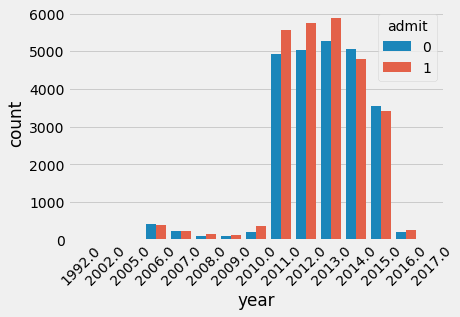

In [113]:
plt.xticks(rotation=45)
sns.countplot(data=data, x="year", hue="admit")


### Feature Selection

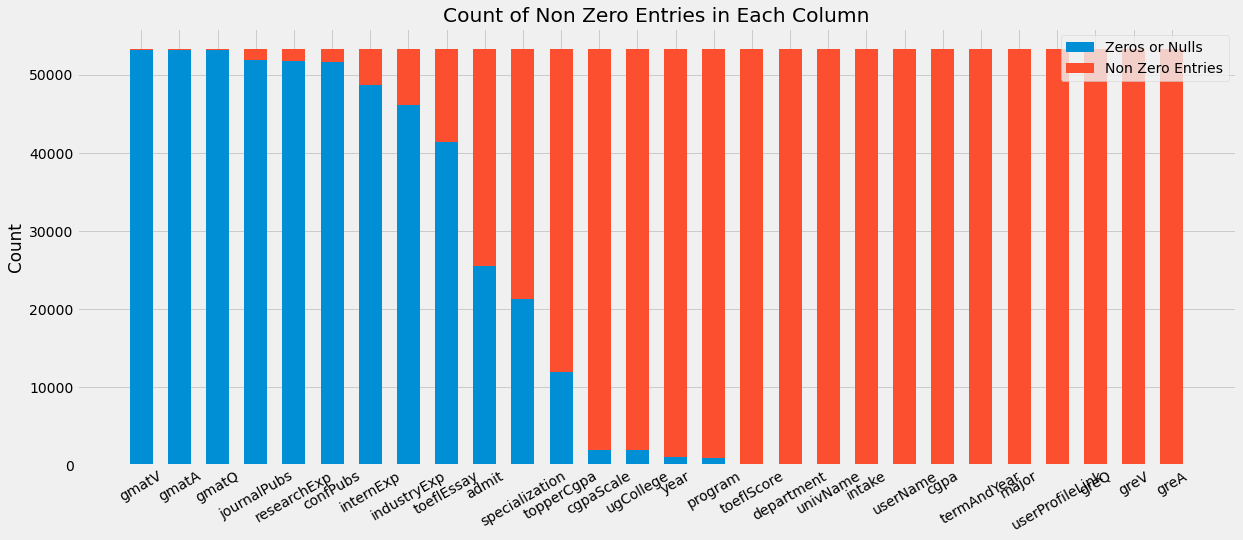

In [114]:
df_binary = data.copy(deep=True)
df_binary = df_binary.fillna(0)
stack = df_binary.stack()
stack[ stack != 0] = 1
df_binary = stack.unstack()

col = []
final_l = [[], []]
for i in df_binary.columns:
    col.append(i)
    val_count = df_binary[i].value_counts()
    final_l[0].append(val_count[0] if 0 in val_count else 0)
    final_l[1].append(val_count[1] if 1 in val_count else 0)

    
df = pd.DataFrame(final_l, columns=col,index=["Zeros", "Non Zeros"]).T
df = df.sort_values('Zeros', ascending=False)


fig, ax = plt.subplots()
fig.set_size_inches(18.5, 7.5)
ax.tick_params(axis='x', labelrotation = 30)
ax.bar(df.index, df.loc[:,"Zeros"], 0.6, label='Zeros or Nulls')
ax.bar(df.index, df.loc[:,"Non Zeros"], 0.6,  bottom=df.loc[:,"Zeros"], label='Non Zero Entries')

ax.set_ylabel('Count')
ax.set_title('Count of Non Zero Entries in Each Column')
ax.legend()

plt.show()

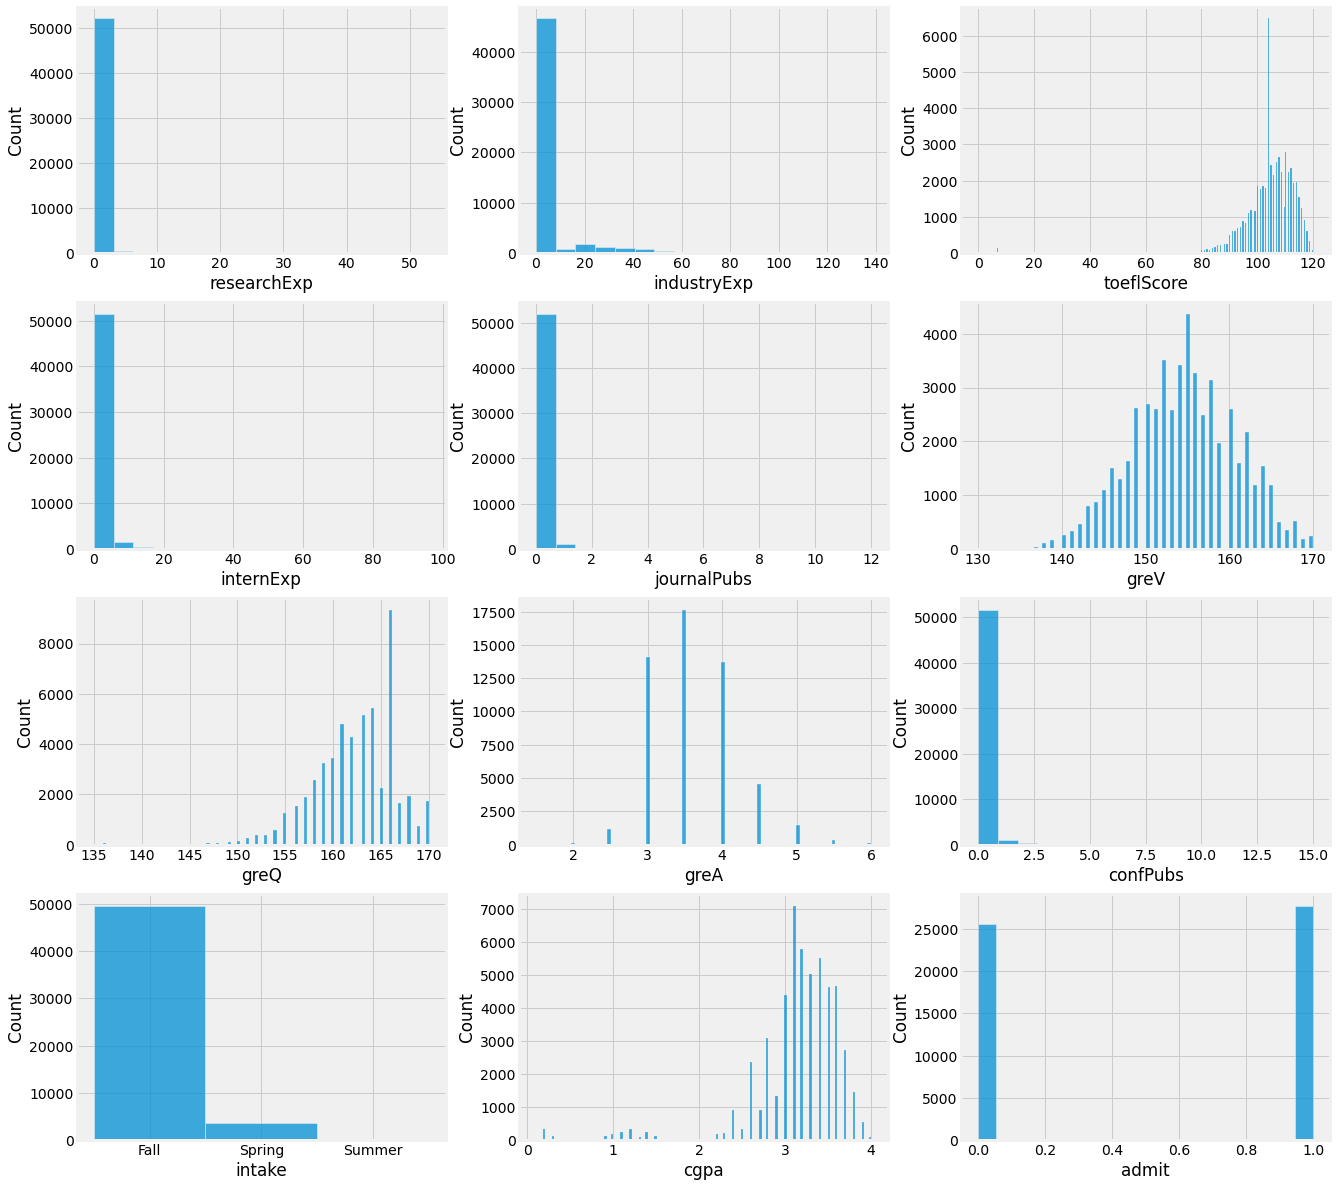

In [115]:
hist_feature = ["researchExp", "industryExp", "toeflScore", "internExp", "journalPubs", "greV", "greQ", "greA", "confPubs", "intake", "cgpa", "admit"]

hist_data = data[hist_feature]

plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for continuous_feature in hist_data.columns:
    ax = plt.subplot(12,3,plotnumber)
    sns.histplot(hist_data[continuous_feature])
    plt.xlabel(continuous_feature)
    plotnumber+=1
plt.show()




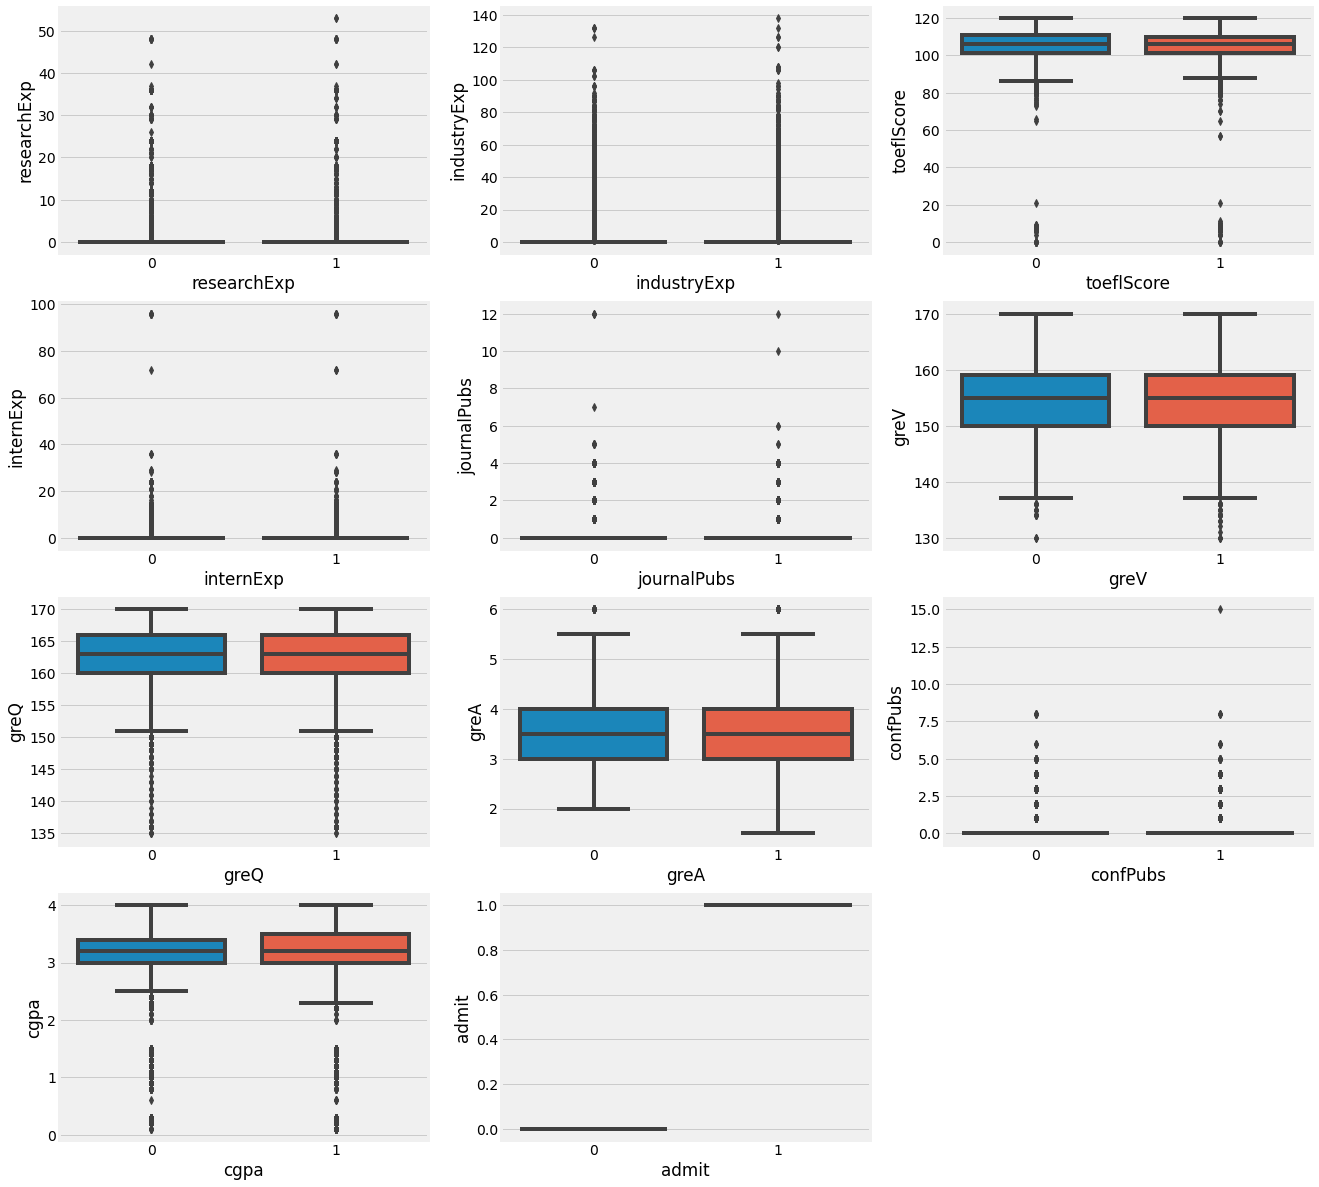

In [116]:
box_feature = ["researchExp", "industryExp", "toeflScore", "internExp", "journalPubs", "greV", "greQ", "greA", "confPubs",  "cgpa", "admit"]

box_data = data[box_feature]
plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for feature in box_data.columns:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(x="admit", y= box_data[feature], data=box_data)
    plt.xlabel(feature)
    plotnumber+=1
plt.show()

## Why we Dropping these columns:
* Specialization: had 3620 unique entries, many of them were re-entry of same name in different format, many were garbage values, Not relevant so we dropped
* Username: is not relevant
* UserProfile link: is not relevant
* ToeflEssay: does not exist in real life
* All GMAT's: have around 120 entries only out of 53199 total entries
* UG College : 1823 unique values in UG College, no way to rank them, usually doesn't influence admit decision unless you are from IIT, Hence Dropped
* Department : UG College Department 1487 unique values in UG College, no way to rank them, usually doesn't influence admit decision, Hence Dropped
* TopperCGPA : Irrelevant column
* researchExp : Majorly contains only 0's, does not add any new information
* industryExp : Majorly contains only 0's, does not add any new information
* internExp : Majorly contains only 0's, does not add any new information
* journalPubs : Majorly contains only 0's, does not add any new information
* confPubs : Majorly contains only 0's, does not add any new information

## Reducing features and outlier removal of certain numeric features

In [117]:
ml_data = data[["major", "toeflScore", "greV", "greQ", "greA", "cgpa", "intake", "univName", "admit"]]

In [118]:
    
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (2 * IQR)
    upper_range = Q3 + (2 * IQR)
    return lower_range,upper_range

    
for feature in ["toeflScore", "greV", "greQ", "greA", "cgpa"]:
    lowerbound, upperbound = outlier_treatment(ml_data[feature])
    print("For Column: ", feature, " ->  Range:", lowerbound, " To ", upperbound)
    print("Total outliers removed: ", len(ml_data[(ml_data[feature] < lowerbound) | (ml_data[feature] > upperbound)]))
    print()
    values = ml_data[(ml_data[feature] < lowerbound) | (ml_data[feature] > upperbound)]
    ml_data.drop(values.index, inplace=True)
    

For Column:  toeflScore  ->  Range: 83.0  To  128.0
Total outliers removed:  597

For Column:  greV  ->  Range: 132.0  To  177.0
Total outliers removed:  8

For Column:  greQ  ->  Range: 148.0  To  178.0
Total outliers removed:  229

For Column:  greA  ->  Range: 1.0  To  6.0
Total outliers removed:  0

For Column:  cgpa  ->  Range: 2.0  To  4.5
Total outliers removed:  1877



## Pair plot

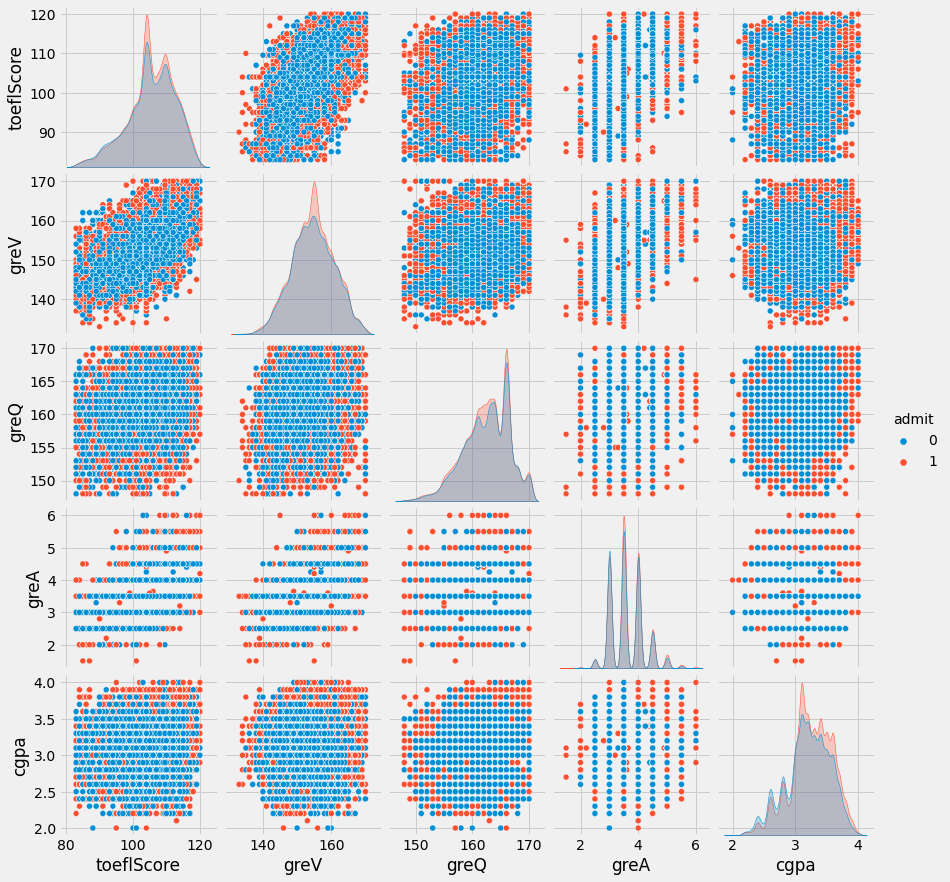

In [119]:
sns.pairplot(ml_data, hue="admit", vars=["toeflScore", "greV", "greQ", "greA", "cgpa"])

# Cluster Analysis on World University Ranking

In [120]:


df = pd.read_csv(world_rank_data)
df = df[df.location == "United States"]
df.reset_index(drop=True, inplace=True)
df.replace("501+", 502, inplace=True)
df.replace("601+", 602, inplace=True)
df['ifr rank'] = pd.to_numeric(df["ifr rank"])
df['ar rank'] = pd.to_numeric(df["ar rank"])
df['er rank'] = pd.to_numeric(df["ar rank"])
df['fsr rank'] = pd.to_numeric(df["ar rank"])
df['cpf rank'] = pd.to_numeric(df["ar rank"])
df['isr rank'] = pd.to_numeric(df["ar rank"])
df['irn rank'] = pd.to_numeric(df["ar rank"])
df['ger rank'] = pd.to_numeric(df["ar rank"])
df = df.iloc[:,4:-1]
df = df.iloc[:, ::2]



df = df.dropna() # Because none of our university have NA's
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df)


pca = PCA(n_components = 2)
pca.fit(scaled_features)
data_pca = pca.transform(scaled_features)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2'])



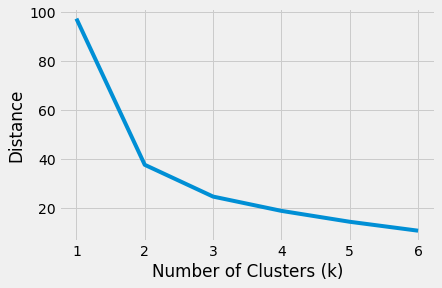

In [121]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.style as style

range_n_clusters = [1, 2, 3, 4, 5, 6]
avg_distance=[]
for n_clusters in range_n_clusters:
  clusterer = KMeans(n_clusters=n_clusters, random_state=42).fit(data_pca)
  avg_distance.append(clusterer.inertia_)

style.use("fivethirtyeight")
plt.plot(range_n_clusters, avg_distance)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distance")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.5586034035746508
For n_clusters = 3 The average silhouette_score is : 0.49517463990703997
For n_clusters = 4 The average silhouette_score is : 0.38532544145351266
For n_clusters = 5 The average silhouette_score is : 0.3994364873758076
For n_clusters = 6 The average silhouette_score is : 0.43706750107499265


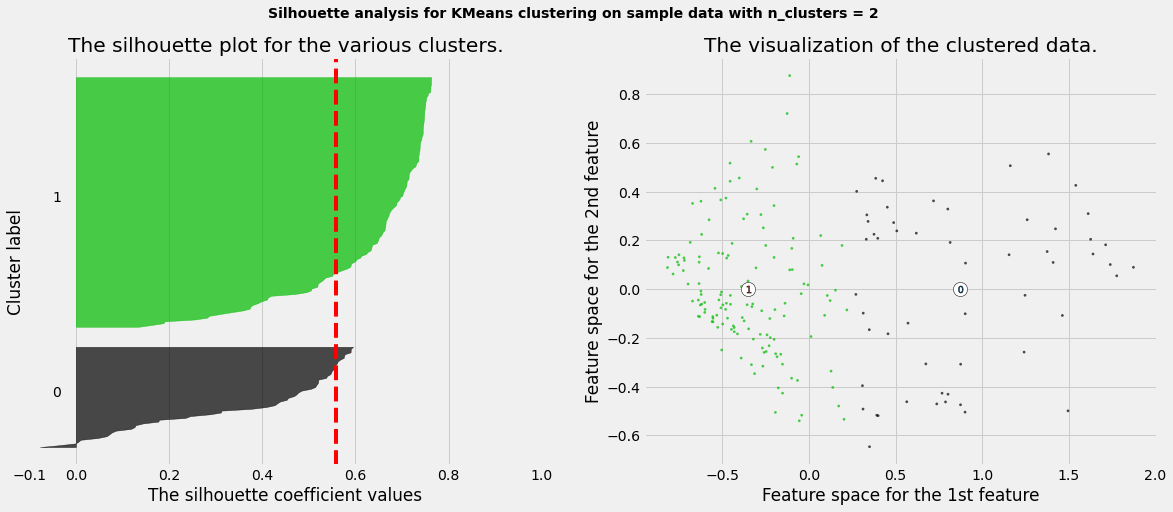

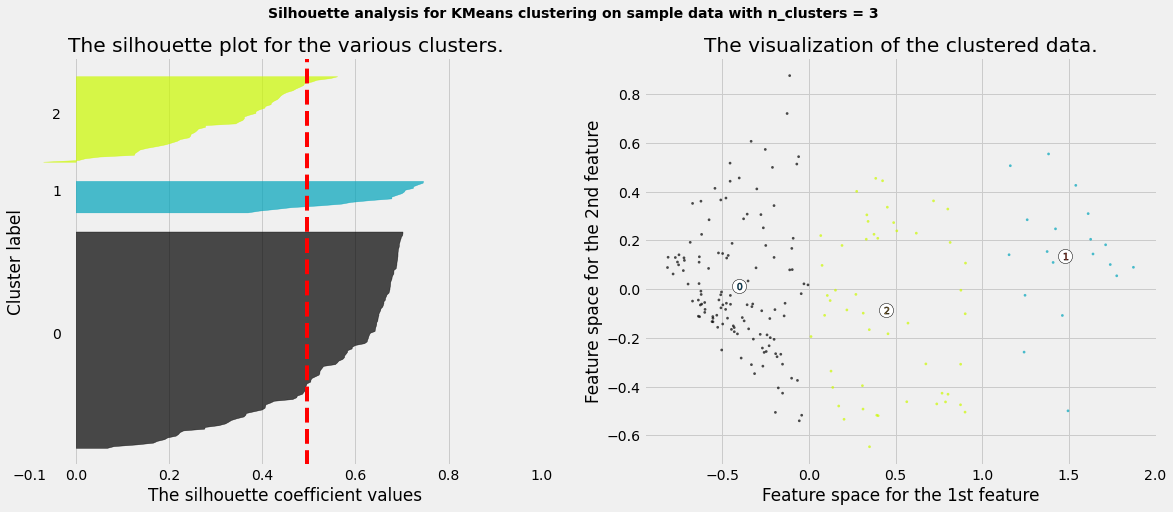

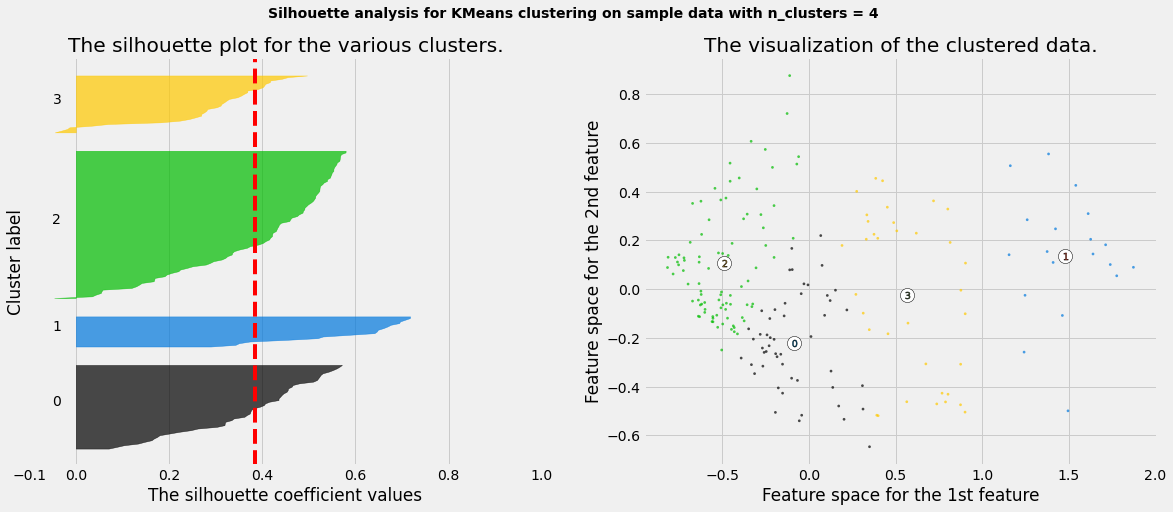

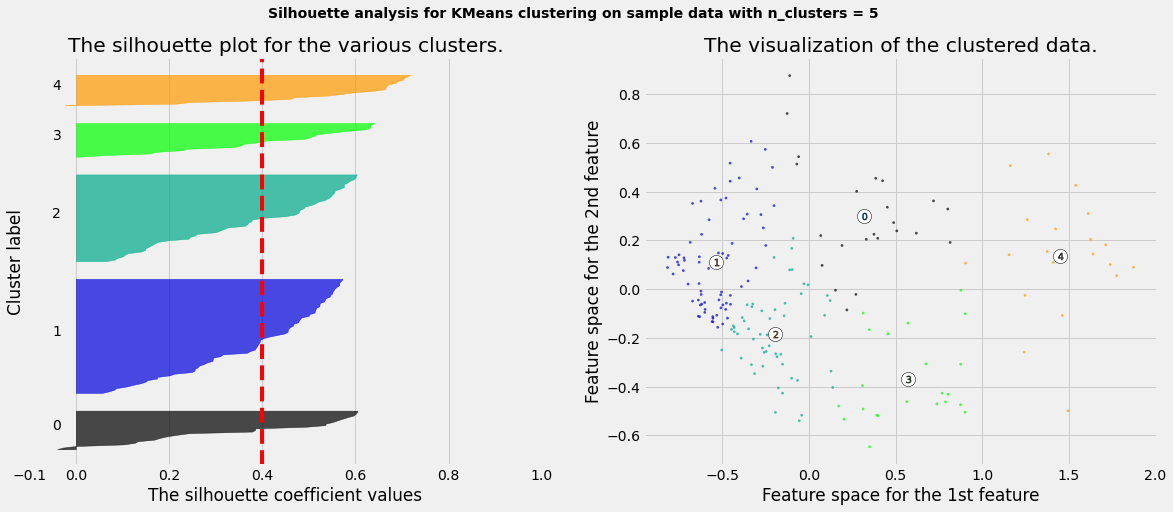

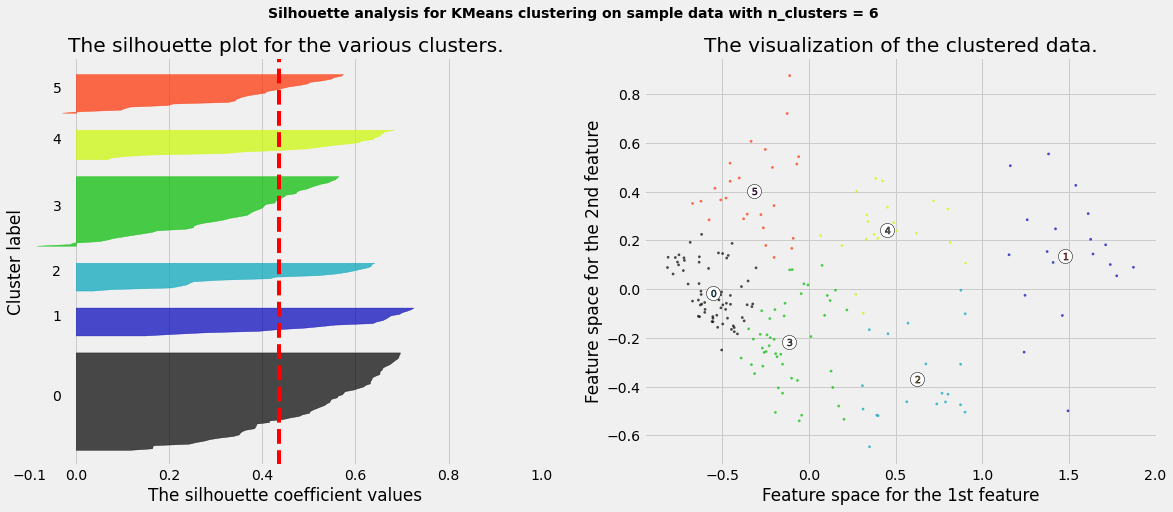

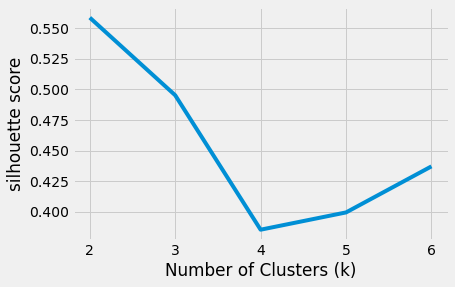

In [122]:
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []
#data_pca = scaled_features
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(data_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data_pca.iloc[:, 0], data_pca.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

In [123]:
def get_tier_list_dict(n_clus):
    kmeans = KMeans(
            init="random",
            n_clusters=n_clus,
            n_init=30,
            max_iter=3000,
            random_state=42
        )

    #kmeans.fit(scaled_features)
    kmeans.fit(data_pca)
    #data_pca['cluster'] = kmeans.labels_
    df1 = pd.read_csv(world_rank_data)
    df1 = df1[df1.location == "United States"]
    df1.dropna(inplace=True)
    df1.reset_index(inplace=True, drop=True)
    data = pd.DataFrame(columns=["UniName", 'Cluster', "Rank"])
    data["UniName"] = df1.institution
    data["Cluster"] = kmeans.labels_
    data["Rank"] = df1.Rank

    tier_list1 = {}
    for val in data.Cluster.unique():
        l = data[data.Cluster == val][["UniName", "Rank"]].to_numpy()
        #print("Class = ", val, "Length = ", len(l))
        for i in l:
            tier_list1[i[0]] = val
            #print(i[0], " -- ", i[1])
        #print("\n\n")

    tier_list = {}

    for i,v in tier_list1.items():
        if "Wisconsin-Madison" in i:
            tier_list["University of Wisconsin Madison"] = v
        elif "ersity of Texas at Austin" in i:
            tier_list["University of Texas Austin"] = v
        elif "he University of Texas at Arlington" in i:
            tier_list["University of Texas Arlington"] = v
        elif "North Carolina, Chapel Hill" in i:
            tier_list["University of North Carolina Chapel Hill"] = v
        elif "North Carolina at Charlotte" in i:
            tier_list["University of North Carolina Charlotte"] = v
        elif "Michigan-Ann" in i:
            tier_list["University of Michigan Ann Arbor"] = v
        elif "Maryland, College Park" in i:
            tier_list["University of Maryland College Park"] = v
        elif "Urbana-Champaign" in i:
            tier_list["University of Illinois Urbana-Champaign"] = v
        elif "llinois at Chicago" in i:
            tier_list["University of Illinois Chicago"] = v
        elif "California, Santa Cruz" in i:
            tier_list["University of California Santa Cruz"] = v
        elif "California, Santa Barbara" in i:
            tier_list["University of California Santa Barbara"] = v
        elif "California, San Diego" in i:
            tier_list["University of California San Diego"] = v
        elif "California, Los Angeles" in i:
            tier_list["University of California Los Angeles"] = v
        elif "California, Irvine" in i:
            tier_list["University of California Irvine"] = v
        elif "California, Davis" in i:
            tier_list["University of California Davis"] = v
        elif "University of Arizona" in i:
            tier_list["University of Arizona"] = v
        elif "Texas A&M" in i:
            tier_list["Texas A and M University College Station"] = v
        elif "Stony Brook" in i:
            tier_list["SUNY Stony Brook"] = v
        elif "Buffalo SUNY" in i:
            tier_list["SUNY Buffalo"] = v
        elif "Rutgers University–New B" in i:
            tier_list["Rutgers University New Brunswick/Piscataway"] = v
        elif "Ohio State" in i:
            tier_list["Ohio State University Columbus"] = v
        elif "New York U" in i:
            tier_list["New York University"] = v
        elif "New Jersey I" in i:
            tier_list["New Jersey Institute of Technology"] = v
        elif "Massachusetts Institute" in i:
            tier_list["Massachusetts Institute of Technology"] = v
        elif "California Institute of Technology" in i:
            tier_list["California Institute of Technology"] = v
        else:
            tier_list[i] = v
    return tier_list

### Scale Data & Final Transformation of Data

In [124]:
def scale_transform_split(ml_data):
    train_data, test_data, y_train, y_test = train_test_split(ml_data.drop(columns="admit"), ml_data.admit, test_size=0.3)
    

    train_data["admit"] = y_train
    test_data["admit"] = y_test


    scaler = MinMaxScaler()

    scale_col = ["toeflScore", "greV", "greQ", "greA", "cgpa"]
    scaler.fit(train_data[scale_col])

    train_data[scale_col] = scaler.transform(train_data[scale_col])
    test_data[scale_col] = scaler.transform(test_data[scale_col])


    x_train, y_train =  train_data.drop(columns = "admit"), train_data.admit
    x_test, y_test =  test_data.drop(columns = "admit"), test_data.admit

    values = y_train.value_counts()
    if  values[0]*0.65 > values[1]:
        df_1 = train_data[train_data['admit'] == 1]
        df_0 = train_data[train_data['admit'] == 0]  
        n_samp = len(df_0) * 0.8
        df_1_upsampled = resample(df_1, random_state=42, n_samples=int(n_samp), replace=True)
        #concatenate the upsampled dataframe
        train_data = pd.concat([df_1_upsampled, df_0])
        
    return x_train, y_train, x_test, y_test

### Models

In [125]:
def predict_SVM(X_train, X_test, y_train, y_test):
    model = svm.SVC(kernel='rbf', C=10, gamma=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result = []
    for metric in (accuracy_score, precision_score, recall_score, f1_score):
        result.append(metric(y_test, y_pred))
    return result

In [126]:
def predict_KNN(X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier()
    model = KNeighborsClassifier(n_neighbors=18, weights='uniform', metric="manhattan")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result = []
    for metric in (accuracy_score, precision_score, recall_score, f1_score):
        result.append(metric(y_test, y_pred))
    return result

In [127]:
def predict_ANN(X_train, X_test, y_train, y_test):
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

    model.fit(X_train, y_train, batch_size=16, epochs=50)


In [128]:
def predict_LR(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    result = []
    for metric in (accuracy_score, precision_score, recall_score, f1_score):
        result.append(metric(y_test, y_pred))
    return result

In [129]:
def predict_LDA(X_train, X_test, y_train, y_test):
    model = LinearDiscriminantAnalysis(solver="svd")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result = []
    for metric in (accuracy_score, precision_score, recall_score, f1_score):
        result.append(metric(y_test, y_pred))
    return result

In [130]:
def predict_NB(X_train, X_test, y_train, y_test):
    model = GaussianNB()
    y_pred = model.fit(X_train, y_train).predict(X_test)
    result = []
    for metric in (accuracy_score, precision_score, recall_score, f1_score):
        result.append(metric(y_test, y_pred))
    return result

In [131]:
def predict_RF(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    result = []
    for metric in (accuracy_score, precision_score, recall_score, f1_score):
        result.append(metric(y_test, y_pred))
    return result

#### Predictions

In [132]:
def predict_models(X_train, X_test, y_train, y_test):
    final_result = [["SVM", "KNN", "LR", "LDA", "Naive Bayes", "Random Forest"]]
    final_result.append(predict_SVM(X_train, X_test, y_train, y_test))
    final_result.append(predict_KNN(X_train, X_test, y_train, y_test))
    #final_result.append(predict_ANN(X_train, X_test, y_train, y_test))
    final_result.append(predict_LR(X_train, X_test, y_train, y_test))
    final_result.append(predict_LDA(X_train, X_test, y_train, y_test))
    final_result.append(predict_NB(X_train, X_test, y_train, y_test))
    final_result.append(predict_RF(X_train, X_test, y_train, y_test))
    return final_result

In [133]:
from IPython.display import display
total_cluster = 2

ml_data["Cluster_Rank"] = ml_data["univName"]
tier_dict = get_tier_list_dict(total_cluster)
ml_data = ml_data.replace({"Cluster_Rank" : tier_dict})

for i in range(total_cluster):
    print("PREDICTION FOR CLUSTER %s" % i)
    
    ml_data_tier = ml_data[ml_data.Cluster_Rank == i]
    ml_data_tier = ml_data_tier.drop(columns="Cluster_Rank")
    
    ml_data_tier = pd.get_dummies(ml_data_tier, columns=['major', "intake", "univName"], drop_first=True)
    X_train, y_train, X_test, y_test = scale_transform_split(ml_data_tier)
    
    result = predict_models(X_train, X_test, y_train, y_test)
    result_df = pd.DataFrame(result[1:], index=result[0], columns=["accuracy_score", "precision_score", "recall_score", "f1_score"])
    display(result_df)
    #result_df.to_excel(f"tot_{total_cluster}_clust_{i}.xlsx")
    #print("---------------------------------------------------------------")

PREDICTION FOR CLUSTER 0


,accuracy_score,precision_score,recall_score,f1_score
SVM,0.746065,0.766960,0.840870,0.802216
KNN,0.738347,0.766559,0.823573,0.794044
LR,0.718523,0.739750,0.833704,0.783922
LDA,0.717312,0.739820,0.830492,0.782538
Naive Bayes,0.663136,0.724759,0.725476,0.725117
Random Forest,0.739558,0.765768,0.828021,0.795678


PREDICTION FOR CLUSTER 1


,accuracy_score,precision_score,recall_score,f1_score
SVM,0.726594,0.708779,0.657874,0.682378
KNN,0.718316,0.695652,0.656046,0.675269
LR,0.706308,0.692647,0.615043,0.651542
LDA,0.707940,0.695280,0.615565,0.652999
Naive Bayes,0.650227,0.601618,0.640898,0.620637
Random Forest,0.715518,0.692542,0.652390,0.671867


# HyperParameter Tuning

In [134]:
def plot_estimation_probability(probas):
    plt.figure(dpi=100)
    plt.hist(probas, bins=20)
    plt.title('Classification Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('# of Instances')
    plt.xlim([0.5, 1.0])
    plt.legend(["Not Admitted", "Admitted"])
    plt.show()
    
def plot_ROC_Curve(model_name, y_test, probas, class_i, class_name):
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_test, probas[:,class_i], pos_label=class_i)

    roc_auc = auc(fpr, tpr)

    plt.figure(dpi=100)
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.title(f'ROC Curve of {model_name} for class {class_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.show()

In [135]:
from IPython.display import display
total_cluster = 2

ml_data["Cluster_Rank"] = ml_data["univName"]
tier_dict = get_tier_list_dict(total_cluster)
ml_data = ml_data.replace({"Cluster_Rank" : tier_dict})

ml_data_tier0 = ml_data[ml_data.Cluster_Rank == 0]
ml_data_tier1 = ml_data[ml_data.Cluster_Rank == 1]

ml_data_tier0 = ml_data_tier0.drop(columns="Cluster_Rank")
ml_data_tier1 = ml_data_tier1.drop(columns="Cluster_Rank")

print("Tier 1 Universities: ", '\n'.join(ml_data_tier0.univName.unique()), "\n\n")
print("Tier 2 Universities: ",  '\n'.join(ml_data_tier1.univName.unique()))


ml_data_tier0 = pd.get_dummies(ml_data_tier0, columns=['major', "intake", "univName"], drop_first=True)
X_train0, y_train0, X_test0, y_test0 = scale_transform_split(ml_data_tier0)




ml_data_tier1 = pd.get_dummies(ml_data_tier1, columns=['major', "intake", "univName"], drop_first=True)
X_train1, y_train1, X_test1, y_test1 = scale_transform_split(ml_data_tier1)


Tier 1 Universities:  Worcester Polytechnic Institute
Wayne State University
Virginia Polytechnic Institute and State University
University of Utah
University of Texas Dallas
University of Texas Arlington
University of North Carolina Charlotte
University of Illinois Chicago
University of Colorado Boulder
University of Cincinnati
University of California Santa Cruz
University of Arizona
Syracuse University
SUNY Stony Brook
SUNY Buffalo
Rutgers University New Brunswick/Piscataway
North Carolina State University
New Jersey Institute of Technology
George Mason University
Clemson University 


Tier 2 Universities:  University of Wisconsin Madison
University of Washington
University of Texas Austin
University of Southern California
University of Pennsylvania
University of North Carolina Chapel Hill
University of Minnesota Twin Cities
University of Michigan Ann Arbor
University of Massachusetts Amherst
University of Maryland College Park
University of Illinois Urbana-Champaign
University of F

## KNN HyperParameter Tuning

In [136]:
X_train0, y_train0, X_test0, y_test0
results = []
error_rate = []
for neighbors in range(1, 18):
    model = KNeighborsClassifier(n_neighbors=neighbors, weights='uniform', metric="manhattan")
    model.fit(X_train0, y_train0)
    pred_i = model.predict(X_test0)
    results.append(pred_i)
    error_rate.append(np.mean(pred_i != y_test0))

Text(0, 0.5, 'Error Rate')

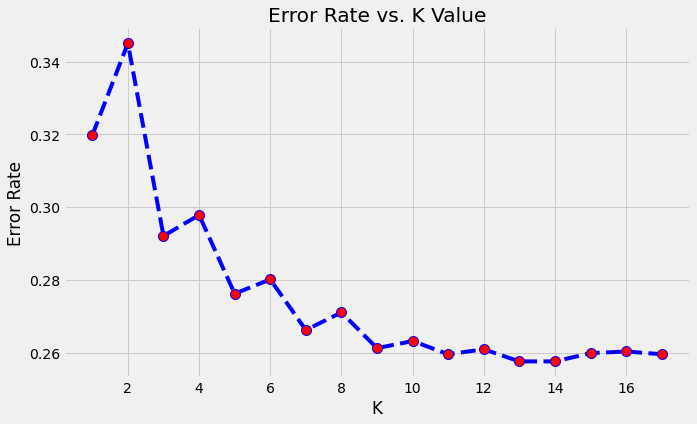

In [137]:
plt.figure(figsize=(10,6))
plt.plot(range(1,18),error_rate,color="blue", linestyle="dashed", marker="o",
 markerfacecolor="red", markersize=10)
plt.title("Error Rate vs. K Value")
plt.xlabel("K")
plt.ylabel("Error Rate")

In [138]:
X_train1, y_train1, X_test1, y_test1
results = []
error_rate = []
for neighbors in range(1, 18):
    model = KNeighborsClassifier(n_neighbors=neighbors, weights='uniform', metric="manhattan")
    model.fit(X_train1, y_train1)
    pred_i = model.predict(X_test1)
    results.append(pred_i)
    error_rate.append(np.mean(pred_i != y_test1))

Text(0, 0.5, 'Error Rate')

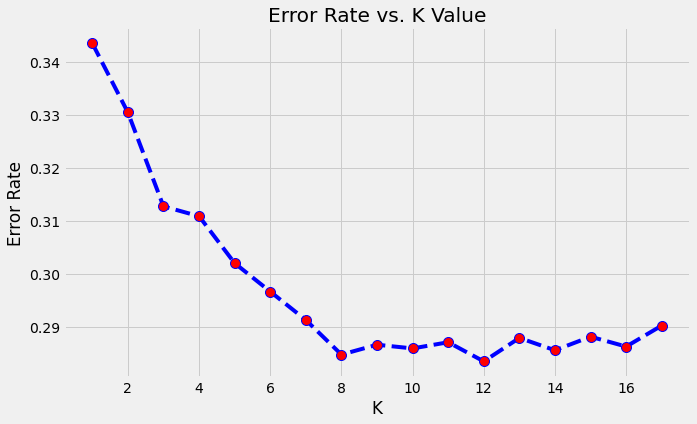

In [139]:
plt.figure(figsize=(10,6))
plt.plot(range(1,18),error_rate,color="blue", linestyle="dashed", marker="o",
 markerfacecolor="red", markersize=10)
plt.title("Error Rate vs. K Value")
plt.xlabel("K")
plt.ylabel("Error Rate")

### Choosing K = 8 or K = 5

In [140]:
n_neighbors = [5, 8]
p=[1,2]
hyperparameters = dict(n_neighbors=n_neighbors, p=p)
knn_2 = KNeighborsClassifier()
clf = GridSearchCV(knn_2, hyperparameters, cv=3, verbose=3, n_jobs=-1)
best_model = clf.fit(X_train0, y_train0)
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best leaf_size: 30
Best p: 2
Best n_neighbors: 8



 Prediction for tier 1 Universities 

              precision    recall  f1-score   support

           0       0.65      0.66      0.65      2539
           1       0.78      0.78      0.78      4069

    accuracy                           0.73      6608
   macro avg       0.72      0.72      0.72      6608
weighted avg       0.73      0.73      0.73      6608



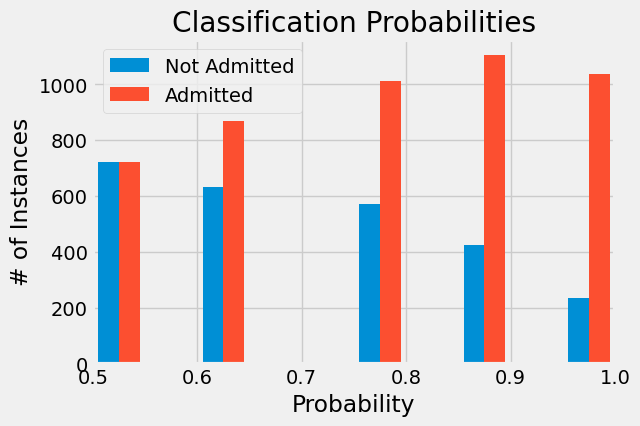

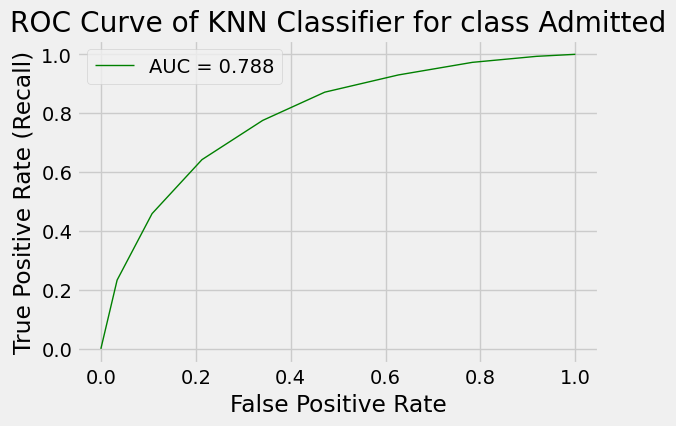


 Prediction for tier 2 Universities 

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      4741
           1       0.70      0.60      0.65      3836

    accuracy                           0.71      8577
   macro avg       0.70      0.70      0.70      8577
weighted avg       0.71      0.71      0.70      8577



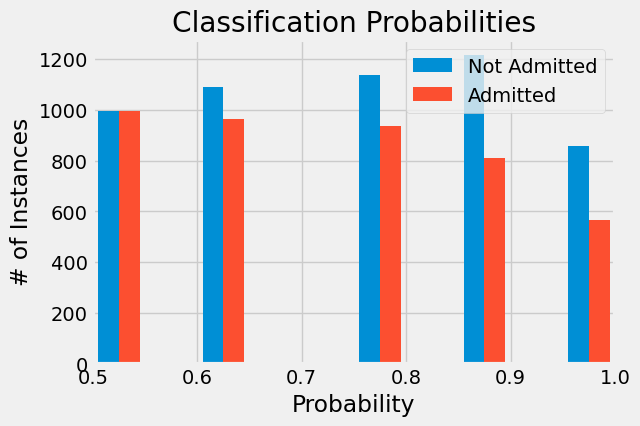

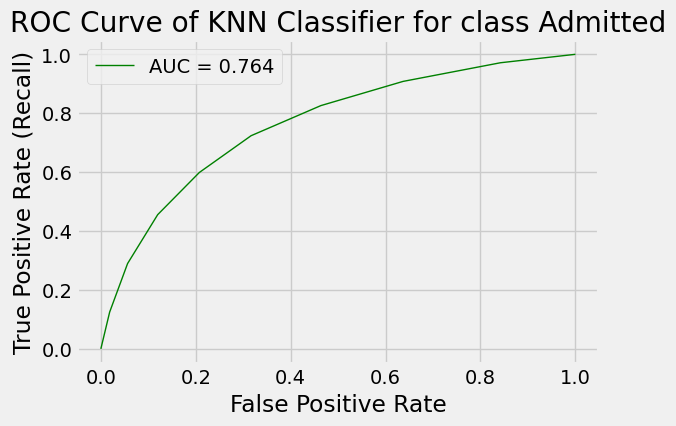

In [143]:
for tier, i in enumerate([[X_train0, y_train0, X_test0, y_test0], [X_train1, y_train1, X_test1, y_test1]]):
    model = KNeighborsClassifier(n_neighbors=8, leaf_size= 30,  weights='uniform', p= 2)
    model.fit(i[0], i[1])
    pred_i = model.predict(i[2])
    print("\n Prediction for tier %s Universities \n" % str(tier+1))
    print(classification_report(i[3], pred_i))
    probas = model.predict_proba(i[2])
    
    plot_estimation_probability(probas)
    #plot_ROC_Curve("KNN Classifier", i[3], probas, 0, "Not Admitted")
    plot_ROC_Curve("KNN Classifier", i[3], probas, 1, "Admitted")

### SVM HyperParameter Tuning

In [34]:
param_grid = {'C': [1, 2], 
              'gamma': [1, 0.01],
              'kernel': ['rbf', 'poly']} 
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, n_jobs=-1, cv=2)

grid.fit(X_train0, y_train0)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly']},
             verbose=3)

In [35]:
grid.best_estimator_

SVC(C=1, gamma=1, kernel='poly')


 Prediction for tier 1 Universities 

              precision    recall  f1-score   support

           0       0.70      0.60      0.64      2536
           1       0.77      0.84      0.80      4072

    accuracy                           0.75      6608
   macro avg       0.74      0.72      0.72      6608
weighted avg       0.74      0.75      0.74      6608



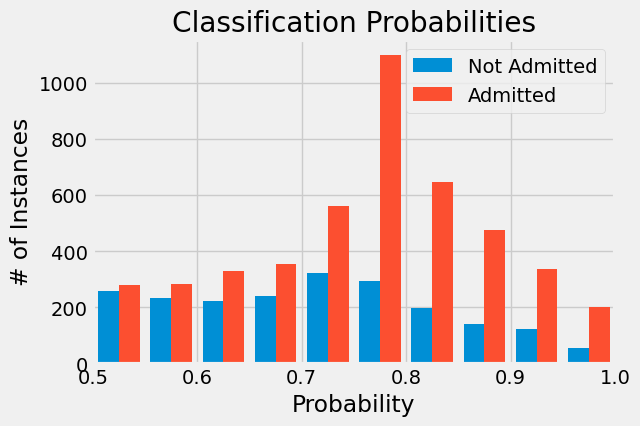

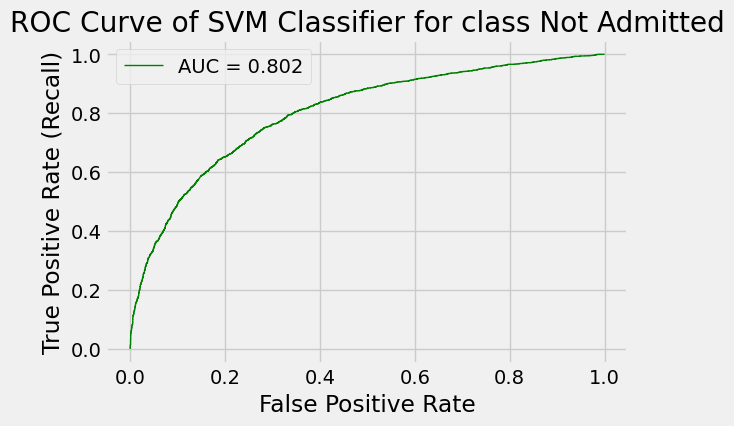

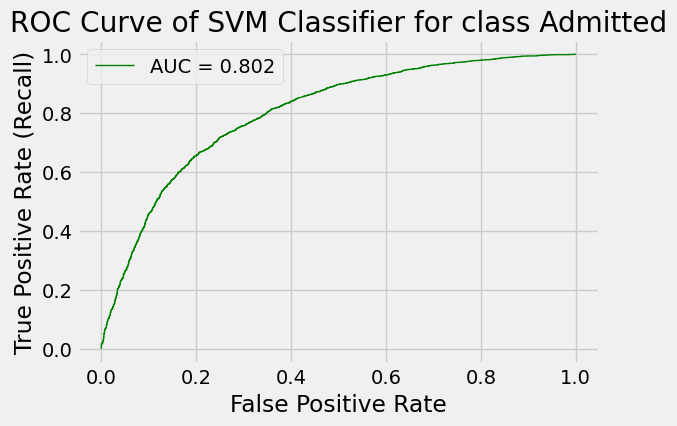


 Prediction for tier 2 Universities 

              precision    recall  f1-score   support

           0       0.74      0.79      0.77      4785
           1       0.71      0.65      0.68      3792

    accuracy                           0.73      8577
   macro avg       0.73      0.72      0.72      8577
weighted avg       0.73      0.73      0.73      8577



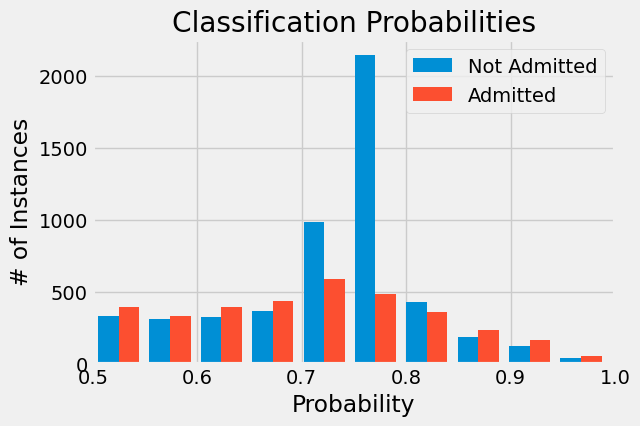

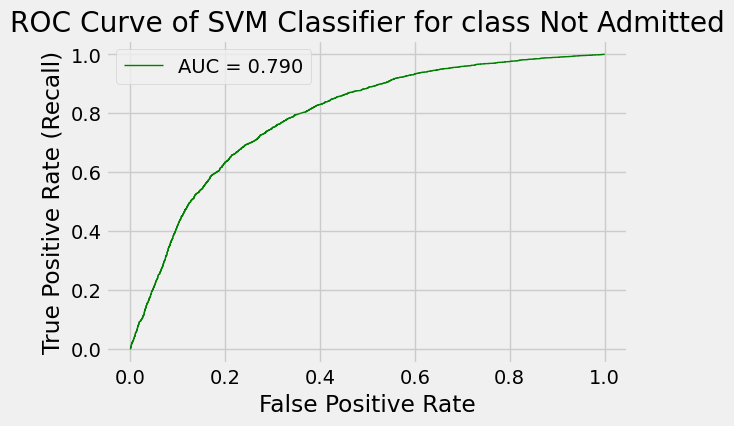

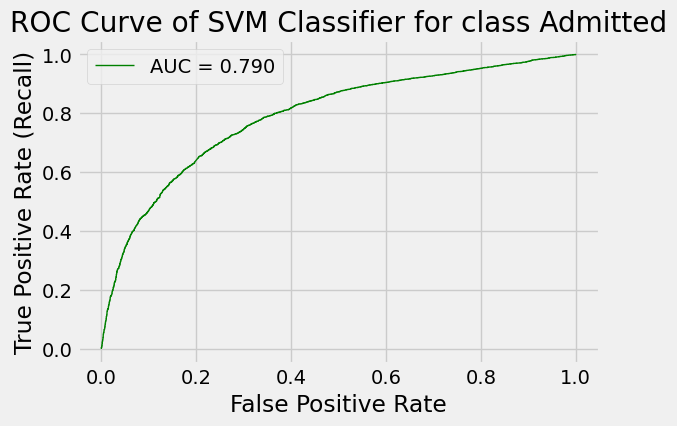

In [69]:
for tier, i in enumerate([[X_train0, y_train0, X_test0, y_test0], [X_train1, y_train1, X_test1, y_test1]]): 
    model = svm.SVC(C=1, gamma=1, kernel='poly', probability=True)
    model.fit(i[0], i[1])
    pred_i = model.predict(i[2])
    print("\n Prediction for tier %s Universities \n" % str(tier+1))
    print(classification_report(i[3], pred_i))
    probas = model.predict_proba(i[2])
    plot_estimation_probability(probas)
    plot_ROC_Curve("SVM Classifier", i[3], probas, 0, "Not Admitted")
    plot_ROC_Curve("SVM Classifier", i[3], probas, 1, "Admitted")

### Random Forest HyperParameter Tuning

In [40]:
param_grid = {  'bootstrap': [True],
              'max_depth': [700, 1000, 1500, 2000, None], 
              'max_features': ['auto', 'log2'], 
              'n_estimators': [400, 500, 700, 1000]}

rfc = RandomForestClassifier()

g_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 

                          cv = 3, n_jobs = -1, verbose = 3, return_train_score=True)

g_search.fit(X_train0, y_train0);

print(g_search.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}



 Prediction for tier 1 Universities 

              precision    recall  f1-score   support

           0       0.69      0.60      0.64      2536
           1       0.77      0.83      0.80      4072

    accuracy                           0.74      6608
   macro avg       0.73      0.71      0.72      6608
weighted avg       0.74      0.74      0.74      6608



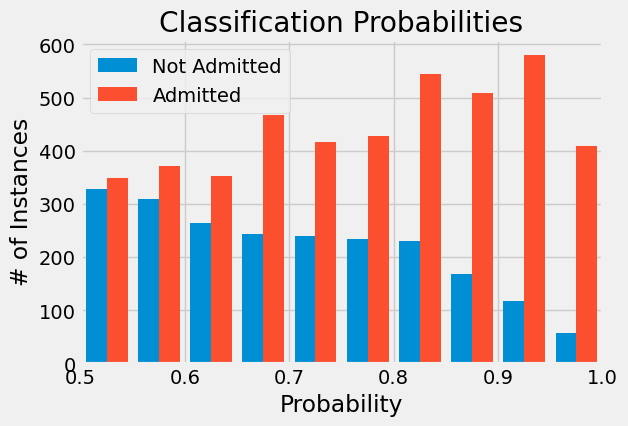

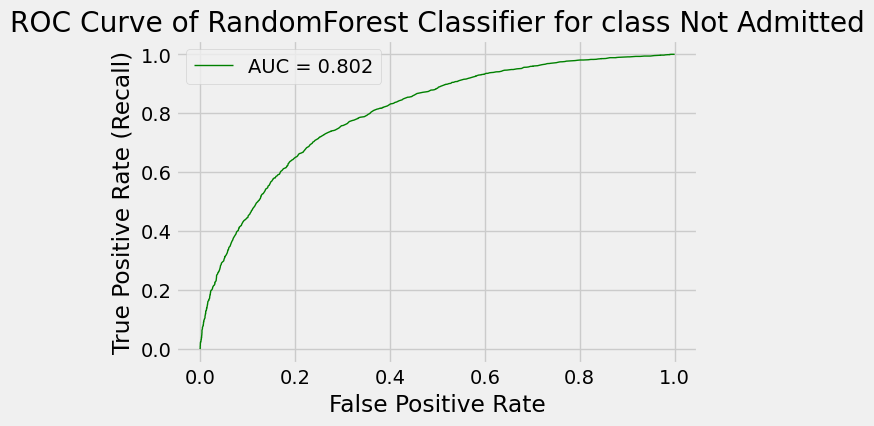

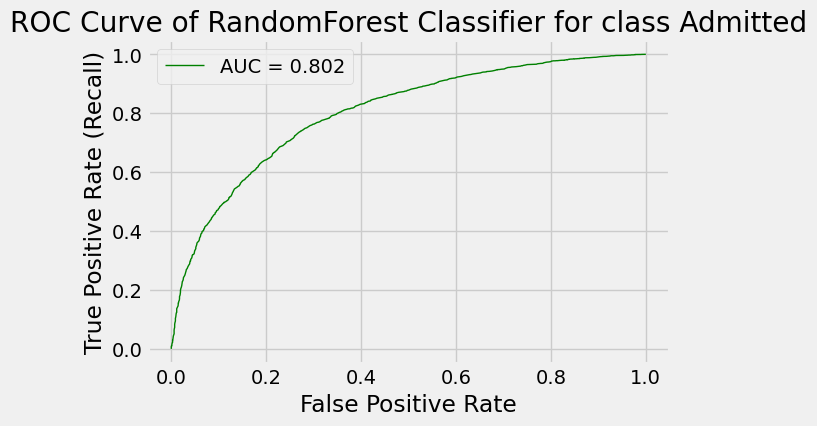

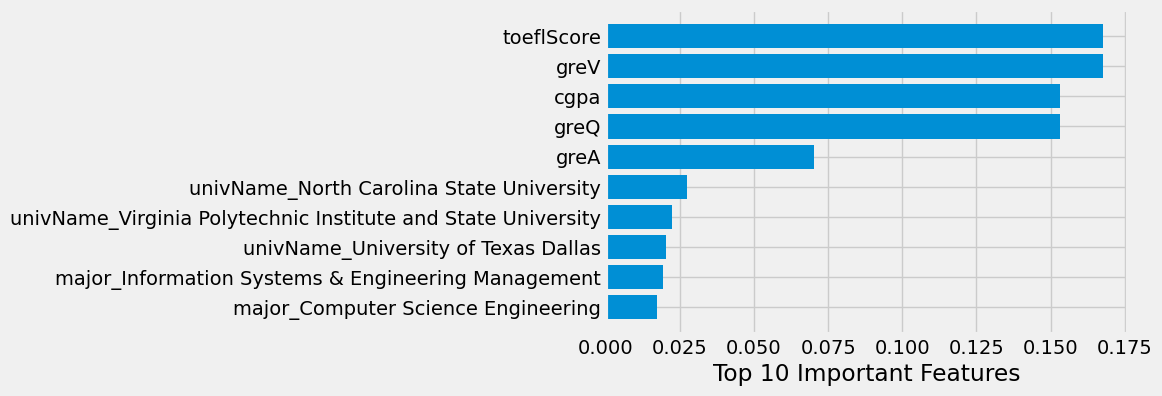


 Prediction for tier 2 Universities 

              precision    recall  f1-score   support

           0       0.74      0.77      0.76      4785
           1       0.70      0.66      0.68      3792

    accuracy                           0.72      8577
   macro avg       0.72      0.72      0.72      8577
weighted avg       0.72      0.72      0.72      8577



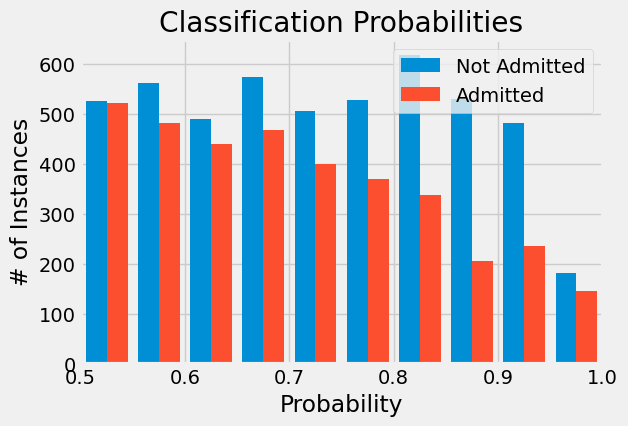

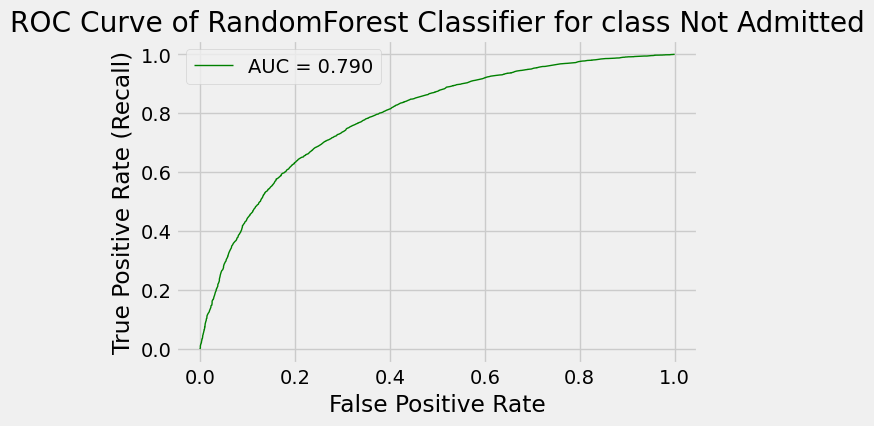

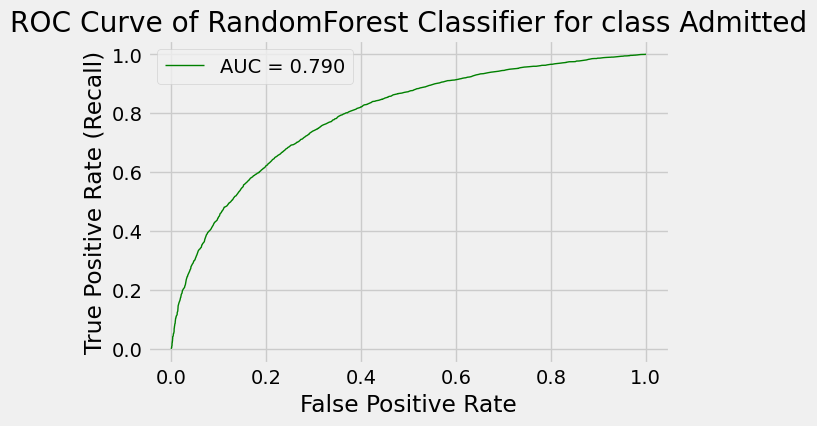

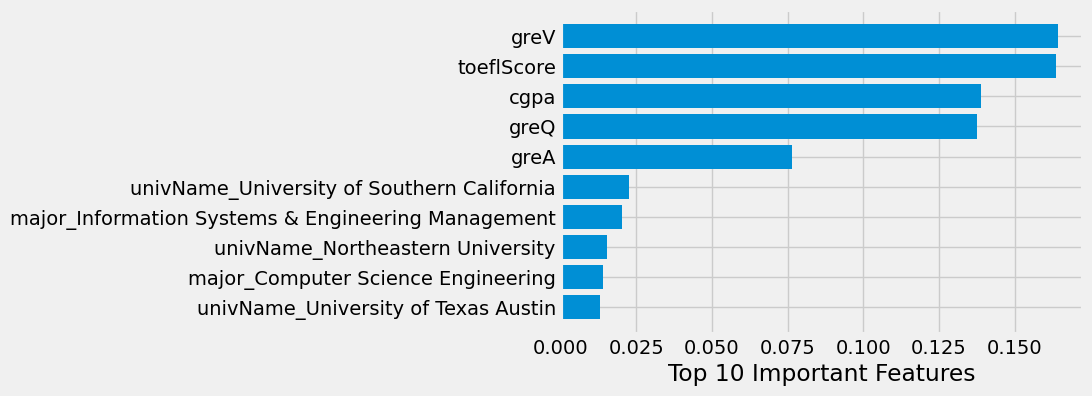

In [89]:
for tier, i in enumerate([[X_train0, y_train0, X_test0, y_test0], [X_train1, y_train1, X_test1, y_test1]]): 
    model = RandomForestClassifier(**{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 500})
    model.fit(i[0], i[1])
    pred_i = model.predict(i[2])
    print("\n Prediction for tier %s Universities \n" % str(tier+1))
    print(classification_report(i[3], pred_i))
    
    probas = model.predict_proba(i[2])
    plot_estimation_probability(probas)
    plot_ROC_Curve("RandomForest Classifier", i[3], probas, 0, "Not Admitted")
    plot_ROC_Curve("RandomForest Classifier", i[3], probas, 1, "Admitted")
    
    sorted_idx = model.feature_importances_.argsort()
    sorted_idx = sorted_idx[-10:]
    plt.figure(dpi=100)
    #plt.xticks(rotation = 60)
    plt.barh(i[0].columns[sorted_idx], model.feature_importances_[sorted_idx])
    plt.xlabel("Top 10 Important Features")
    plt.show()